In [179]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org tensorflow tensorflow-addons matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org tensorflow-addons==0.20.0

---------------------------------------------------------------------------------------------

------------------------------------------------------  fin-----------------------------------

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# -------------------------
# Part 1: CycleGAN Model Definition
# -------------------------
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self, g_optimizer, f_optimizer, d_x_optimizer, d_y_optimizer, loss_fn):
        super(CycleGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.f_optimizer = f_optimizer
        self.d_x_optimizer = d_x_optimizer
        self.d_y_optimizer = d_y_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_x, real_y = data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            gen_g_loss = self.loss_fn(tf.ones_like(disc_fake_y), disc_fake_y)
            gen_f_loss = self.loss_fn(tf.ones_like(disc_fake_x), disc_fake_x)
            cycle_loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x)) * self.lambda_cycle
            cycle_loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y)) * self.lambda_cycle
            total_gen_g_loss = gen_g_loss + cycle_loss_x
            total_gen_f_loss = gen_f_loss + cycle_loss_y

            disc_x_loss = self.loss_fn(tf.ones_like(disc_real_x), disc_real_x) + \
                          self.loss_fn(tf.zeros_like(disc_fake_x), disc_fake_x)
            disc_y_loss = self.loss_fn(tf.ones_like(disc_real_y), disc_real_y) + \
                          self.loss_fn(tf.zeros_like(disc_fake_y), disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.d_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.d_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            'gen_g_loss': total_gen_g_loss,
            'gen_f_loss': total_gen_f_loss,
            'disc_x_loss': disc_x_loss,
            'disc_y_loss': disc_y_loss
        }


In [13]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (7, 7), padding='same'),
        layers.ReLU(),
        layers.Conv2DTranspose(3, (7, 7), padding='same')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, (4, 4), strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Conv2D(1, (4, 4), padding='same')
    ])
    return model


In [14]:
# -------------------------
# Part 2: Dataset Loading and Augmentation
# -------------------------
def load_dataset(dataset_path, img_size=(256, 256)):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)  # Automatically detect class folders
    class_labels = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(class_labels[class_name])

    return np.array(images), np.array(labels), class_names


In [ ]:
images, labels = load_images_and_labels("./wheat_leaf")
images = images / 255.0  # Normalisation


In [15]:
# Train CycleGAN
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

cyclegan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan.compile(
    g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_x_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)


In [17]:
# (-------------------------
# Part 3: Data Splitting
# -------------------------
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
valid_generator = train_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    augmented_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 327 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 407 images belonging to 3 classes.


In [ ]:
# Generate augmented images
augmented_path = './wheat_leaf_augmented'
os.makedirs(augmented_path, exist_ok=True)

for class_name in class_names:
    class_dir = os.path.join(augmented_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for img, label in zip(images, labels):
        if label == class_names.index(class_name):  # Augment images per class
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            augmented_img = generator_g.predict(img)[0]
            augmented_img = (augmented_img * 255).astype(np.uint8)  # Scale back to [0, 255]
            img_name = f"augmented_{len(os.listdir(class_dir))}.jpg"
            cv2.imwrite(os.path.join(class_dir, img_name), augmented_img)

In [ ]:
# -------------------------
# Part 4: Train MobileNetV2 Classifier
# -------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [104]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 940ms/step - accuracy: 0.9378 - loss: 0.1740 - val_accuracy: 0.7250 - val_loss: 0.6261
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 634ms/step - accuracy: 0.9532 - loss: 0.1877 - val_accuracy: 0.7750 - val_loss: 0.5572
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 589ms/step - accuracy: 0.9515 - loss: 0.1697 - val_accuracy: 0.7250 - val_loss: 0.6152
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.9725 - loss: 0.1638 - val_accuracy: 0.7500 - val_loss: 0.5879
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9669 - loss: 0.1469 - val_accuracy: 0.7375 - val_loss: 0.6299
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.9810 - loss: 0.1389 - val_accuracy: 0.7750 - val_loss: 0.5547
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.9805 - loss: 0.1222 - val_accuracy: 0.7500 - val_loss: 0.6016
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 588ms/step - accuracy: 0.9813 - loss: 0.1140 - val_accuracy: 0

In [105]:
# -------------------------
# Part 5: Evaluate and Confusion Matrix
# -------------------------
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.9390 - loss: 0.2077
Test Loss: 0.15620717406272888
Test Accuracy: 0.9557739496231079


In [106]:

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes



13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 743ms/step


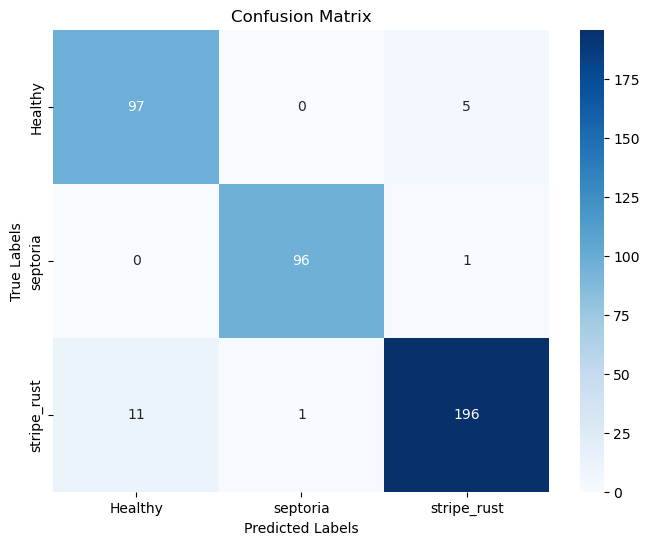


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.90      0.95      0.92       102
    septoria       0.99      0.99      0.99        97
 stripe_rust       0.97      0.94      0.96       208

    accuracy                           0.96       407
   macro avg       0.95      0.96      0.96       407
weighted avg       0.96      0.96      0.96       407



In [107]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [109]:
import cv2
import numpy as np

# Function to predict the label of a single image
def predict_image(model, image_path, class_labels):
    """
    Predicts the label for a given image using the trained model.

    Args:
        model: Trained Keras model (already loaded in memory).
        image_path: Path to the test image.
        class_labels: List of class labels in the same order as the model output.

    Returns:
        The predicted label for the image.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.resize(image, (224, 224))  # Resize to match model's input shape
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Map the predicted index to the corresponding label
    predicted_label = class_labels[predicted_class_index]
    return predicted_label

# Example usage
if __name__ == "__main__":
    # Assuming `model` is already loaded and trained
    # Define the class labels (ensure they match the order used during training)
    class_labels = ["Healthy", "septoria", "stripe_rust"]  # Replace with your actual class names

    # Test with a specific image
    test_image_path = "test.jpg"  # Replace with the path to your test image
    try:
        predicted_label = predict_image(model, test_image_path, class_labels)
        print(f"The predicted label for the test image is: {predicted_label}")
    except Exception as e:
        print(f"Error: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The predicted label for the test image is: septoria
